# Data analysis of a club running paths

In the previous notebook I was preparing the data. Now I can load those data and try to make sens of them.

## Import a few modules

In [1]:
import sys
import numpy as np
import pandas as pd
import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt
import geopy.distance
import glob
import os
import importlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from datetime import datetime

sys.path.append("../my_modules")
import toolToReadGPX as ttrgpx

# Load data

I have a list of file names and a list of DataFrame.

In [3]:
# list of file names
path_csv_files = "../data/csv/"
list_csv_files  = glob.glob(path_csv_files+"*.csv")
list_csv_files.sort()

# list of panda DataFrame
list_run_df = []
for c, f in enumerate(list_csv_files):
    list_run_df.append(pd.read_csv(f))
    
list_run_df[0].head()

,latitude,longitude,elevation,distance,cumulative_distance
0,45.489475,-73.567072,28.0,0.000000,0.000000
1,45.489990,-73.567008,28.4,2.778534,64.942756
2,45.490023,-73.567069,28.4,0.259519,80.830817
3,45.490406,-73.567770,27.2,2.930886,154.253517
4,45.491059,-73.568864,24.4,3.069119,269.001807


# What are the questions I want to answer and visiualization I want to generate?

The data are GPS traces, so the first idea that comes to my mind is *how do look these traces?*

## Display GPS traces

### Display one GPS trace

In [23]:
head_tail = os.path.split(list_csv_files[index_sel])
head_tail[1]

'RunRite_2023_08_17_downSample.csv'

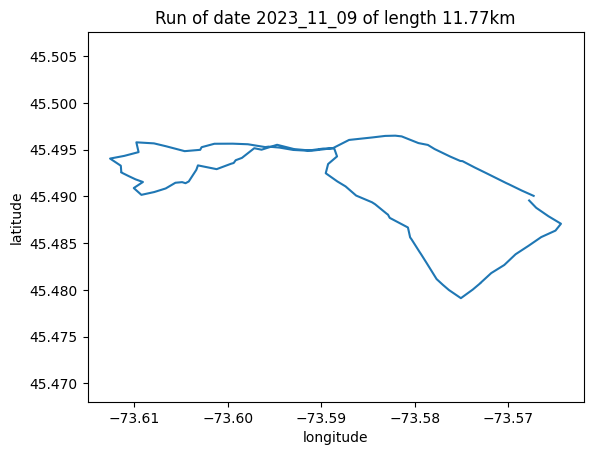

In [29]:
# select one trace randomly
index_sel           = np.random.randint(99)
single_gps_trace_df = list_run_df[index_sel]
head_tail = os.path.split(list_csv_files[index_sel])

plt.plot(single_gps_trace_df["longitude"],single_gps_trace_df["latitude"])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Run of date "+head_tail[1][8:18]+" of length {0:1.2f}km".format(single_gps_trace_df["cumulative_distance"].iloc[-1] / 1000))
plt.axis("equal")
plt.show()

### Display a selected list of GPS traces

#### Random selection

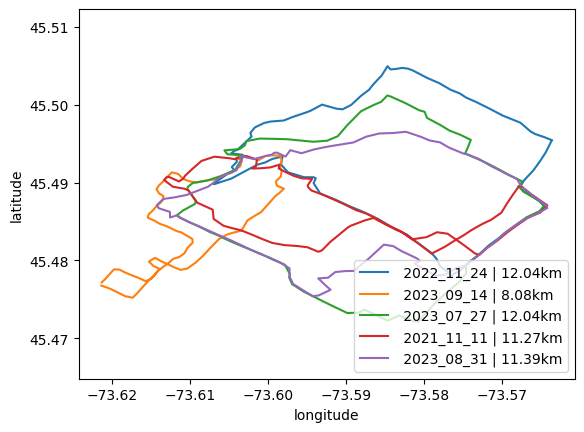

In [30]:
# select randomly several traces
index_sel = np.random.randint(99, size=5)

for c, i in enumerate(index_sel):
    single_gps_trace_df = list_run_df[index_sel[c]]
    head_tail = os.path.split(list_csv_files[i])

    #plot the trace
    plt.plot(single_gps_trace_df["longitude"],single_gps_trace_df["latitude"], label=" "+
             head_tail[1][8:18]+
             " | {0:1.2f}km".format(single_gps_trace_df["cumulative_distance"].iloc[-1] / 1000))

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend(loc="lower right")
plt.axis("equal")
plt.show()

### Selection by date

For example all runs in 2023.

In [35]:
int(head_tail[1][8:12])

2023

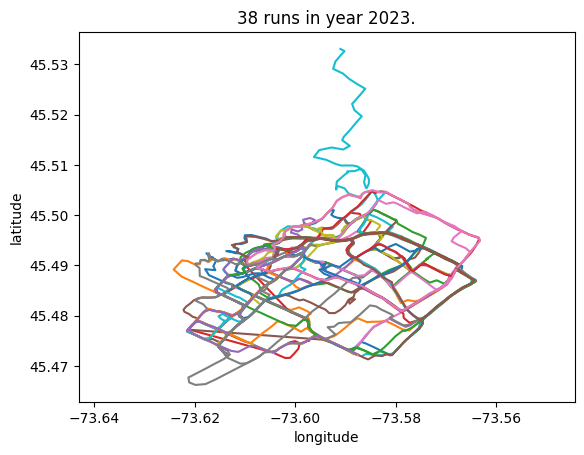

In [37]:
index_sel = []
year_sel = 2023

for c, i in enumerate(list_run_df):
    head_tail = os.path.split(list_csv_files[c])
    
    # check year
    if int(head_tail[1][8:12]) == year_sel:
        index_sel.append(c)
index_sel = np.array(index_sel)

# plot the traces
for c, i in enumerate(index_sel):
    single_gps_trace_df = list_run_df[index_sel[c]]
    plt.plot(single_gps_trace_df["longitude"],single_gps_trace_df["latitude"])

plt.title("{0:1.0f} runs in year {1:1.0f}.".format(index_sel.size, year_sel))
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.axis("equal")
plt.show()

## Re do the same with a better usage of the date as index

To do so I need to convert the index as time index, but also to keep a column as index values 0 to nb trace to access the trace selected.

In [ ]:
all_last_trace_entree_df = pd.DataFrame(columns = ["time","cumulative_distance"],
                                        index=[np.arange(len(list_run_df))])

for c, d in enumerate(list_run_df):
    # reselect the last point of trace corresponding to the final distance of the run
    idxmax_ = list_run_df[c]["cumulative_distance"].idxmax()

    head_tail = os.path.split(list_csv_files[c])
    time_run = head_tail[1][8:18].replace("_","-")
    
    # copy the values time and cumulative distance to the list of run
    all_last_trace_entree_df.iloc[c,1] = list_run_df[c].iloc[idxmax_,4].copy() 
    
    # clean the time value to keep only yy mm dd
    all_last_trace_entree_df.iloc[c,0] = time_run

# format properly the time column
all_last_trace_entree_df["time"] = pd.to_datetime(all_last_trace_entree_df['time'], format='%Y-%m-%d') # format the time column

#convert index to time index
all_last_trace_entree_df = all_last_trace_entree_df.set_index('time') # set the time as index

# add a new column as indexNum 0 to number of traces
all_last_trace_entree_df['indexNum'] = np.arange(len(list_run_df))

# verify we can select by month
all_last_trace_entree_df.head()

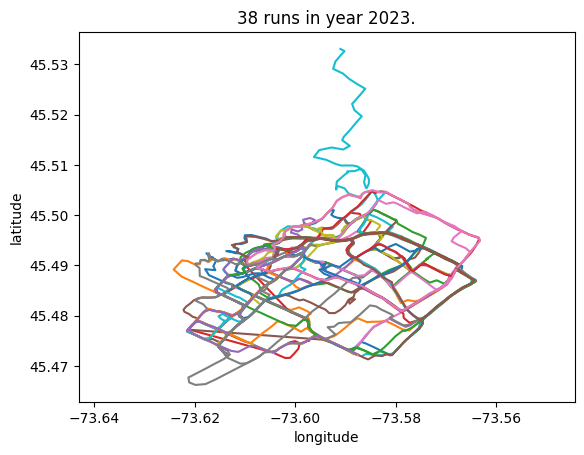

In [56]:
# This below
select_df = all_last_trace_entree_df[all_last_trace_entree_df.index.year == 2023].copy()
index_sel = np.array(select_df["indexNum"].tolist())

# instead of 
#index_sel = []
year_sel = 2023
#for c, i in enumerate(list_run_df):
#    # check year
#    if int(list_run_df[c]["time"][0][0:4]) == year_sel:
#        index_sel.append(c)
#index_sel = np.array(index_sel)

# plot the traces
for c, i in enumerate(index_sel):
    single_gps_trace_df = list_run_df[index_sel[c]]
    plt.plot(single_gps_trace_df["longitude"],single_gps_trace_df["latitude"])

plt.title("{0:1.0f} runs in year {1:1.0f}.".format(index_sel.size, year_sel))
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.axis("equal")
plt.show()

### Select all runs in a single month over all the years

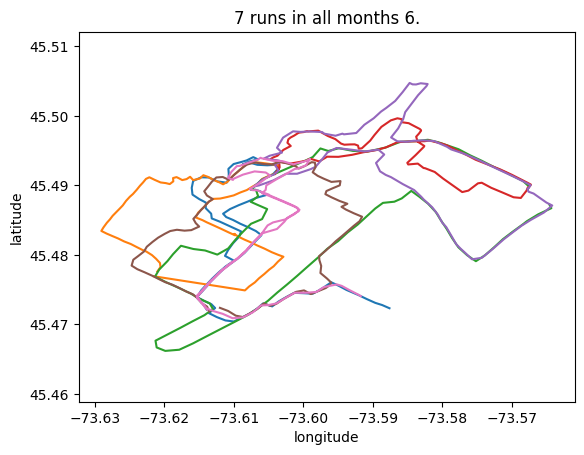

,cumulative_distance,indexNum
time,,
2022-06-09,10924.346612,19
2022-06-30,8611.959407,20
2023-06-01,15485.326613,56
2023-06-08,9667.754797,57
2023-06-15,12943.023408,58


In [57]:
# This below
month_sel = 6
select_df = all_last_trace_entree_df[all_last_trace_entree_df.index.month == month_sel].copy()
index_sel = np.array(select_df["indexNum"].tolist())

# plot the traces
for c, i in enumerate(index_sel):
    single_gps_trace_df = list_run_df[index_sel[c]]
    plt.plot(single_gps_trace_df["longitude"],single_gps_trace_df["latitude"])

plt.title("{0:1.0f} runs in all months {1:1.0f}.".format(index_sel.size, month_sel))
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.axis("equal")
plt.show()

select_df.head()

### Select runs by time interval

For example month1 to month2 in year1

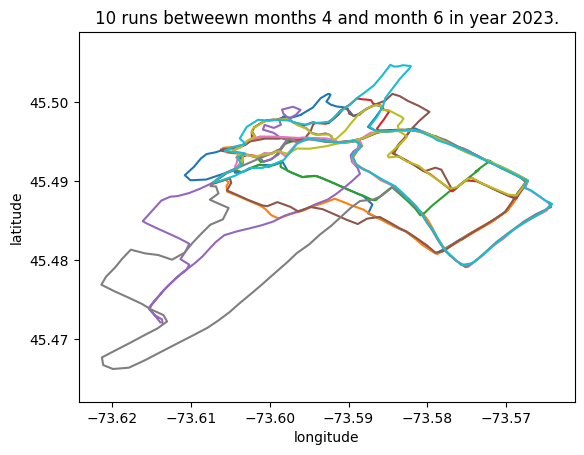

,cumulative_distance,indexNum
time,,
2023-04-06,10514.547896,49
2023-04-13,10965.595223,50
2023-04-20,8394.062073,51
2023-04-27,9490.413417,52
2023-05-04,10468.260842,53
2023-05-23,0.0,54
2023-05-25,9985.961477,55
2023-06-01,15485.326613,56
2023-06-08,9667.754797,57


In [58]:
# This below
month_sel1 = 4
month_sel2 = 6
year_sel  = 2023
select_df = all_last_trace_entree_df[(all_last_trace_entree_df.index.month >= month_sel1) &
(all_last_trace_entree_df.index.month <= month_sel2) &
(all_last_trace_entree_df.index.year == year_sel) ].copy()
index_sel = np.array(select_df["indexNum"].tolist())

# plot the traces
for c, i in enumerate(index_sel):
    single_gps_trace_df = list_run_df[index_sel[c]]
    plt.plot(single_gps_trace_df["longitude"],single_gps_trace_df["latitude"])

plt.title("{0:1.0f} runs betweewn months {1:1.0f} and month {2:1.0f} in year {3:1.0f}.".format(index_sel.size, month_sel1, month_sel2, year_sel))
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.axis("equal")
plt.show()

select_df

## Answer questions about the data

### What was the longest run? How long and when?

In [59]:
idx_longest_run = all_last_trace_entree_df["cumulative_distance"].idxmax()

RUN_LENGHT = all_last_trace_entree_df["cumulative_distance"][idx_longest_run] / 1000
print("The longest run lasted {0:1.2f}km and took place the {1:1.0f}/{2:1.0f}/{3:1.0f}.".format(RUN_LENGHT, 
                                                                                               idx_longest_run.day,
                                                                                               idx_longest_run.month,
                                                                                               idx_longest_run.year))

The longest run lasted 15.77km and took place the 11/7/2024.


Let's display the corresponding trace.

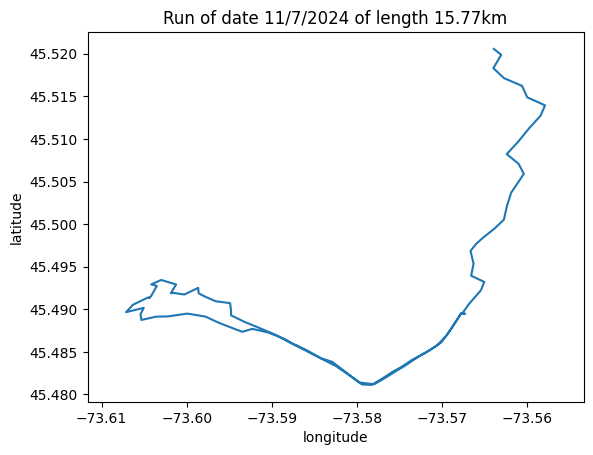

98


In [60]:
index_sel = all_last_trace_entree_df["indexNum"][idx_longest_run]
single_gps_trace_df = list_run_df[index_sel]

plt.plot(single_gps_trace_df["longitude"],single_gps_trace_df["latitude"])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Run of date {1:1.0f}/{2:1.0f}/{3:1.0f} of length {0:1.2f}km".format(RUN_LENGHT, 
                                                                               idx_longest_run.day,
                                                                               idx_longest_run.month,
                                                                               idx_longest_run.year))
plt.axis("equal")

plt.show()
print(index_sel)

# Create reference points for the graphs

The run has different starting points since the beginning of the club:
+ NDG1 first Ciele address
+ NDG2 at the park on Girouard
+ NDG3 from the to other park
+ NDG4 from Espace Ciele

Text(0, 0.5, 'latitude')

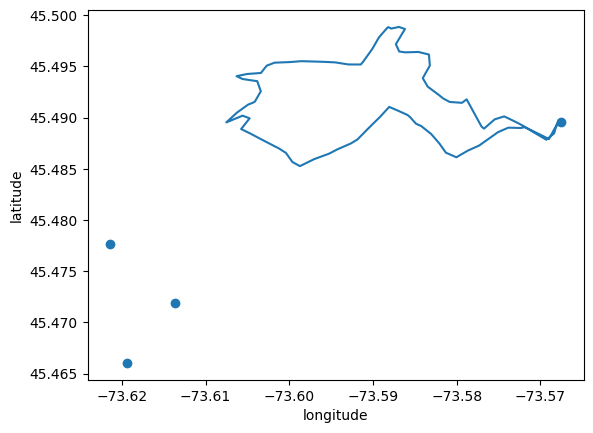

In [61]:
startingPoint_df = pd.DataFrame(columns=["latitude", "longitude"], index=np.arange(4))
startingPoint_df["latitude"][0]= 45.46604
startingPoint_df["longitude"][0]= -73.6194
startingPoint_df["latitude"][1]= 45.471895
startingPoint_df["longitude"][1]= -73.613628

startingPoint_df["latitude"][2]= 45.4776919
startingPoint_df["longitude"][2]= -73.62141
startingPoint_df["latitude"][3]= 45.489528
startingPoint_df["longitude"][3]= -73.567539
startingPoint_df


plt.scatter(startingPoint_df["longitude"],startingPoint_df["latitude"])
#plt.plot(startingPoint_df["longitude"],startingPoint_df["latitude"])

index_sel = 37#np.random.randint(99)
single_gps_trace_df = list_run_df[index_sel]
plt.plot(single_gps_trace_df["longitude"],single_gps_trace_df["latitude"])

plt.xlabel("longitude")
plt.ylabel("latitude")

### Some extra data cleaning
I want a function that takes a trace as input.

I want a function that returns a trace minus the distance done to a reference checkpoint.

To do so I will compute the distance of each trace point to a reference point. The minumum distance will give the index of the corresponding starting point.

The function can do the same to towards the end of the run in case I did not stop my watch after the run ended.